# 1. Import the required libraries

In [ ]:
# Standard code libraries
import os
import numpy as np
import pandas as pd
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt


# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import EmgDataGroup

config = Config()

%matplotlib widget

## 2. Load sEMG test data

## Synthetic data

In [2]:
# For the test data:
base_path = config.get_directory('test_data')

files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='*',
    extension_regex='Poly5',
    folder_levels=None,
    verbose=False
)
button_list = ipy_widgets.file_select(
    files=files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])

interactive(children=(Dropdown(description='files:', options=('emg_data_synth_pocc.Poly5', 'emg_data_synth_qui…

## Patient data

In [3]:
# # Identify all recordings available for the selected patient/measurement_date

# # First find the patients
# config = Config()
# base_path = config.get_directory('root_patient_data')
# patient_paths = file_discovery.find_folders(
#     base_path,
#     folder_levels=['patient'])
# patient = list(patient_paths['patient'].values)[0]

# # Then find the files for the selected patients:
# folder_levels = ['date', 'measurement']
# patient_path = os.path.join(base_path, patient)

# emg_files = file_discovery.find_files(
#     base_path=patient_path,
#     file_name_regex='EMG_recording',
#     extension_regex='poly5',
#     folder_levels=folder_levels)

# folder_levels = ['date', 'measurement']
# vent_files = file_discovery.find_files(
#     base_path=patient_path,
#     file_name_regex='Draeger_recording',
#     extension_regex='poly5',
#     folder_levels=folder_levels)

# button_list = ipy_widgets.file_select(
#     emg_files,
#     folder_levels=folder_levels,
#     default_value_select=None,
#     default_idx_select=[1, 6, None])
# emg_file_chosen = os.path.join(
#     patient_path, *[btn.value for btn in button_list], 'EMG_recording.Poly5')
# vent_file_chosen = os.path.join(
#     patient_path, *[btn.value for btn in button_list], 'Draeger_recording.Poly5')

# print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

In [4]:
# Load the EMG from the selected folders (synthetic data):
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in button_list])

# # Load the EMG from the selected folders:
# emg_file_chosen = os.path.join(patient_path, *[btn.value for btn in button_list])

data_emg = Poly5Reader(emg_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate

y_emg = data_emg_samples
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]

# Load the Ventilator from the selected folders:
# data_vent = Poly5Reader(vent_file_chosen)
# data_vent_samples = data_vent.samples[:data_vent.num_samples]
# fs_vent = data_vent.sample_rate
# 
# y_vent = data_vent_samples
# t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]


Reading file  C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/test_data\emg_data_synth_pocc.Poly5
	 Number of samples:  860160 
	 Number of channels:  2 
	 Sample rate: 2048 Hz
Done reading data.


In [5]:
# Store the EMG data in a group of TimeSeries objects
if y_emg.shape[0] == 2:
    emg_timeseries_wav_den = EmgDataGroup(
        y_emg,
        fs=fs_emg,
        labels=['ECG', 'EMGdi'],
        units=2*['uV'])
    emg_timeseries_gated = EmgDataGroup(
        y_emg,
        fs=fs_emg,
        labels=['ECG', 'EMGdi'],
        units=2*['uV'])
else:
    emg_timeseries_wav_den = EmgDataGroup(
        y_emg,
        fs=fs_emg,
        labels=['ECG', 'EMGdi', 'EMGpara'],
        units=3*['uV'])
    emg_timeseries_gated = EmgDataGroup(
        y_emg,
        fs=fs_emg,
        labels=['ECG', 'EMGdi', 'EMGpara'],
        units=3*['uV'])


# # Store the ventilator data in a group of TimeSeries objects
# vent_timeseries = VentilatorDataGroup(
#     y_vent,
#     fs=fs_vent,
#     labels=['Paw', 'F', 'Vvent'],
#     units=['cmH2O', 'L/s', 'L'])

Auto-detected ECG channel from labels.
Auto-detected ECG channel from labels.


# 3. Pre-process the data

In [6]:
# Gating for comparison
emg_timeseries_gated.filter(
    signal_type='raw',
    hp_cf=20.0,
    lp_cf=500.0,    
    channel_idxs=None,
)
emg_timeseries_gated.gating()
emg_timeseries_gated.envelope()

Auto-detected ECG channel from labels.


# 4. Perform wavelet transform

In [7]:
# Gating for comparison
emg_timeseries_wav_den.filter(
    signal_type='raw',
    hp_cf=20.0,
    lp_cf=500.0,    
    channel_idxs=None,
)
emg_timeseries_wav_den.wavelet_denoising(fixed_threshold=8.0, overwrite=True)
emg_timeseries_wav_den.envelope()

Auto-detected ECG channel from labels.


(0.0, 20.0)

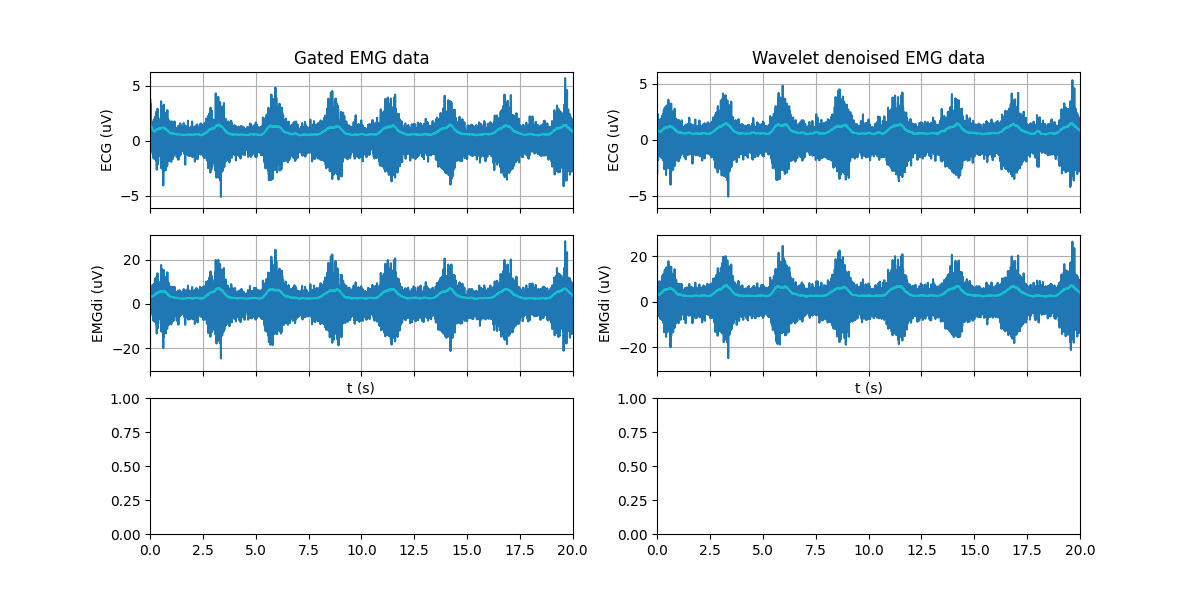

In [8]:
# Plot filtering effect
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axes_emg_gated = axis[:len(emg_timeseries_gated.channels), 0]
axes_emg_wav_den = axis[:len(emg_timeseries_wav_den.channels), 1]
colors = ['tab:cyan', 'tab:orange']
channel_idx = 0


# emg_timeseries.plot_full(
#     axes=axes_emg, signal_type='raw', baseline_bool=False)

emg_timeseries_gated.plot_full(
    axes=axes_emg_gated, signal_type='clean', baseline_bool=False)

emg_timeseries_gated.plot_full(
    axes=axes_emg_gated, signal_type='env', colors=colors)

axes_emg_gated[0].set_title('Gated EMG data')
axes_emg_gated[-1].set_xlabel('t (s)')
# axes_emg_gated[-1].set_ylim([0, 8])

emg_timeseries_wav_den.plot_full(
    axes=axes_emg_wav_den, signal_type='clean', baseline_bool=False)

emg_timeseries_wav_den.plot_full(
    axes=axes_emg_wav_den, signal_type='env', colors=colors)

axes_emg_wav_den[0].set_title('Gated EMG data')
axes_emg_wav_den[-1].set_xlabel('t (s)')

axes_emg_wav_den[0].set_title('Wavelet denoised EMG data')
axes_emg_wav_den[-1].set_xlabel('t (s)')
# axes_emg_wav_den[-1].set_ylim([0, 8])

axes_emg_wav_den[-1].set_xlim([0, 20])

# Compare speed of running median filters

In [9]:
signal = y_emg
win_len = 5 * fs_emg
k = 0
result_median_filter = median_filter(np.abs(signal[k, :]), size=win_len) / 0.6745
win_len

10240

In [10]:
k = 0
result_pd = pd.Series(np.abs(signal[k, :])).rolling(
        window=win_len,
        min_periods=1,
        center=True).median().values / 0.6745
win_len

10240

In [11]:
start_i = 2000
np.array([
    result_median_filter,
    result_pd,
])[:, start_i:start_i+5]

array([[32.36283401, 32.36283401, 32.36283401, 32.36283401, 32.36283401],
       [33.84725742, 33.84780601, 33.85224706, 33.85668812, 33.85851205]])

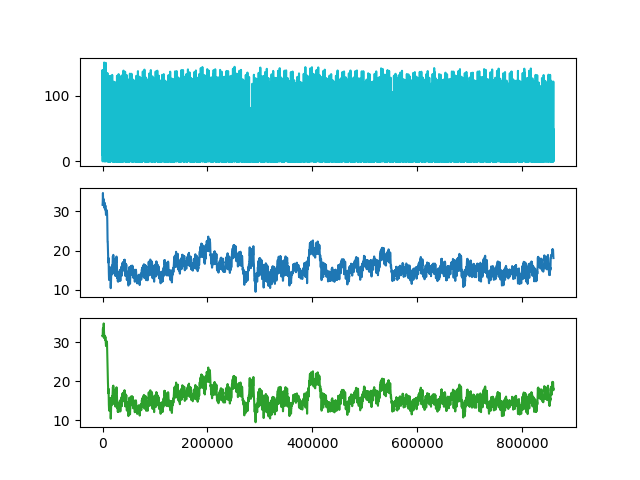

In [12]:
fig, axis = plt.subplots(nrows=3, sharex=True)

axis[0].plot(np.abs(signal[k, :]), 'tab:cyan')
axis[1].plot(result_median_filter, 'tab:blue')
axis[2].plot(result_pd, 'tab:green')